Importing necessary libraries

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [24]:
import xml.etree.ElementTree as ET
from PIL import Image
from pathlib import Path
from skimage import filters
from skimage.color import rgb2gray
from sklearn.decomposition import PCA
from skimage import data, exposure, img_as_float
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_distances
from skimage.feature import hog

1) Use images from ALL FOUR classes

In [2]:
parent_folder = 'crop_images'

In [3]:
class_folders = [f for f in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, f))]

In [21]:
def collect_image_paths(directory, max_images_per_folder=2):
    image_paths = []
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            images = os.listdir(folder_path)
            cropped_images = [image for image in images if image.lower().endswith('.jpg')][:max_images_per_folder]
            for image in cropped_images:
                image_path = os.path.join(folder_path, image)
                image_paths.append(image_path)
    return image_paths


cropped_images_dir = 'crop_images'
image_paths = collect_image_paths(cropped_images_dir)
print(image_paths)

['crop_images\\n02096177-cairn\\n02096177_1000_resize.jpg', 'crop_images\\n02096177-cairn\\n02096177_10031_resize.jpg', 'crop_images\\n02096294-Australian_terrier\\n02096294_1111_resize.jpg', 'crop_images\\n02096294-Australian_terrier\\n02096294_1121_resize.jpg', 'crop_images\\n02100735-English_setter\\n02100735_10030_resize.jpg', 'crop_images\\n02100735-English_setter\\n02100735_10038_resize.jpg', 'crop_images\\n02111500-Great_Pyrenees\\n02111500_1031_resize.jpg', 'crop_images\\n02111500-Great_Pyrenees\\n02111500_1048_resize.jpg']


In [27]:
import matplotlib as plt

2) Convert the images to edge histograms. (Assignment 1 - These will be the vector representations of the
images). This will be your dataset for Part 3. 

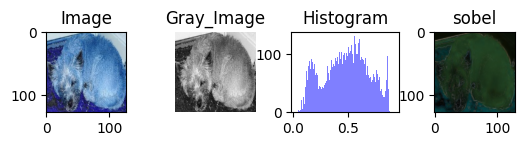

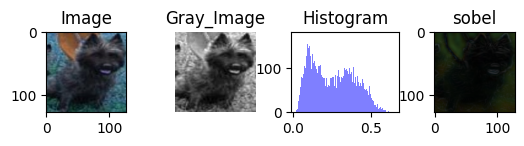

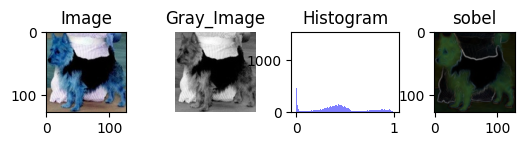

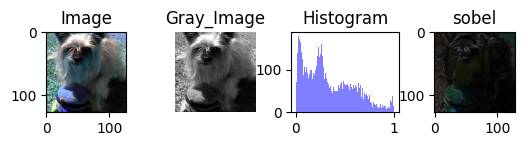

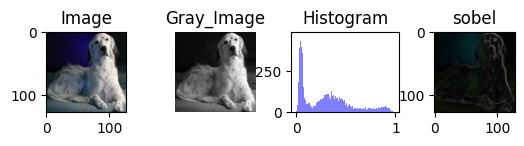

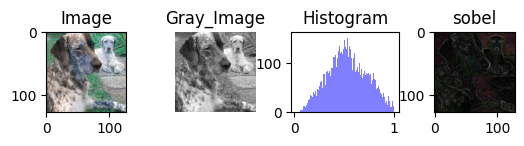

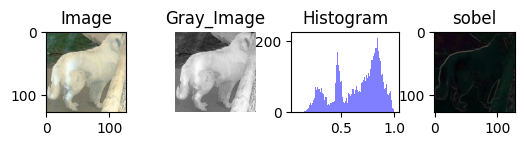

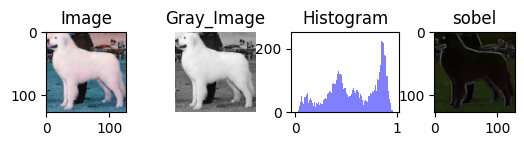

In [26]:
for dog_path in image_paths:
    image = cv2.imread(dog_path)
    grey_image = rgb2gray(image)
    sobel_image = filters.sobel(image)
    # print(dog)
    fig = plt.figure()
    fig.add_subplot(441)
    plt.title('Image')
    plt.imshow(image)
    fig.add_subplot(442)
    plt.title('Gray_Image')
    plt.imshow(grey_image, cmap=plt.get_cmap('gray')) 
    plt.axis('off')
    fig.add_subplot(443)
    plt.title('Histogram')
    plt.hist(grey_image.ravel(), bins=256, color='b', alpha=0.5)
    fig.add_subplot(444)
    plt.title('sobel')
    plt.imshow(sobel_image,cmap=plt.get_cmap('gray'))
    plt.show()

In [28]:
data = []
labels = []
for class_folder in class_folders:
    class_path = os.path.join(parent_folder, class_folder)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        image = cv2.imread(img_path)
        edge_hist = image_to_edge_histogram(image)
        data.append(edge_hist)
        labels.append(class_folder)

3) Split the dataset into a training set and a test set: For each class, perform a training/test split of 80/20

In [6]:
X = np.array(data)
y = np.array(labels)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

4) Perform standardization on the training dataset. 

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

print(f'Scaled training data shape: {X_train_scaled.shape}')
print(f'Test data shape: {X_test.shape}')

Scaled training data shape: (613, 180)
Test data shape: (154, 180)


5) Perform standardization on the test dataset using the means and variances you obtained from the training
dataset

In [12]:
# Standardize test data
X_test_scaled = scaler.transform(X_test)

6) (Model Selection) Perform a standard 5-fold cross-validation and a stratified 5-fold cross-validation
on the training set (i.e., the standardized edge histogram dataset obtained from the training set) for
k-Nearest Neighbor Classifiers such that 𝑘 = 1, 3, 5, 7, 10, 20. 

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

In [48]:
# Define the range of k values
k_values = [1, 3, 5, 7, 10, 20]

# Initialize lists to store mean errors
mean_val_errors_std = []
mean_train_errors_std = []
mean_val_errors_stratified = []
mean_train_errors_stratified = []

# Standard 5-fold cross-validation
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    val_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)
    mean_val_errors_std.append(1 - np.mean(val_scores))
    mean_train_errors_std.append(1 - knn.fit(X_train_scaled, y_train).score(X_train_scaled, y_train))

# Stratified 5-fold cross-validation
skf = StratifiedKFold(n_splits=5)
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    val_scores = cross_val_score(knn, X_train_scaled, y_train, cv=skf)
    mean_val_errors_stratified.append(1 - np.mean(val_scores))
    mean_train_errors_stratified.append(1 - knn.fit(X_train_scaled, y_train).score(X_train_scaled, y_train))

- Plot the (3) confusion matrices for using three approaches (clearly label the classes) on the test set

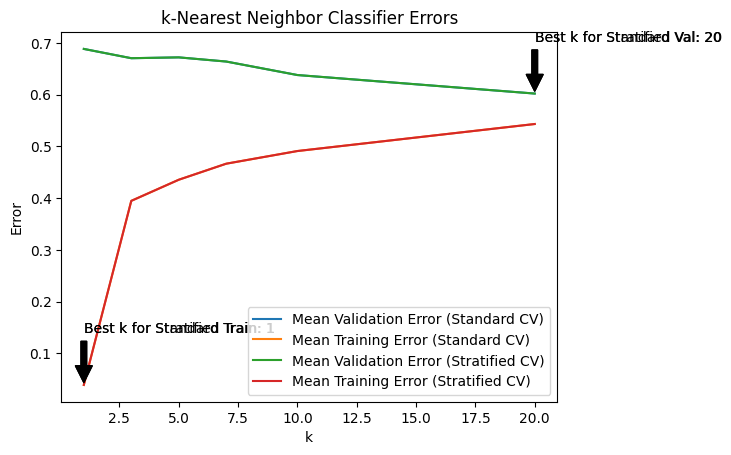

In [55]:

# Plotting
plt.plot(k_values, mean_val_errors_std, label='Mean Validation Error (Standard CV)')
plt.plot(k_values, mean_train_errors_std, label='Mean Training Error (Standard CV)')
plt.plot(k_values, mean_val_errors_stratified, label='Mean Validation Error (Stratified CV)')
plt.plot(k_values, mean_train_errors_stratified, label='Mean Training Error (Stratified CV)')

# Find the k with lowest mean error for each curve
best_k_std_val = k_values[np.argmin(mean_val_errors_std)]
best_k_std_train = k_values[np.argmin(mean_train_errors_std)]
best_k_strat_val = k_values[np.argmin(mean_val_errors_stratified)]
best_k_strat_train = k_values[np.argmin(mean_train_errors_stratified)]

# Annotate the lowest mean errors
plt.annotate('Best k for Standard Val: {}'.format(best_k_std_val), xy=(best_k_std_val, min(mean_val_errors_std)),
             xytext=(best_k_std_val, min(mean_val_errors_std) + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Best k for Standard Train: {}'.format(best_k_std_train), xy=(best_k_std_train, min(mean_train_errors_std)),
             xytext=(best_k_std_train, min(mean_train_errors_std) + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Best k for Stratified Val: {}'.format(best_k_strat_val), xy=(best_k_strat_val, min(mean_val_errors_stratified)),
             xytext=(best_k_strat_val, min(mean_val_errors_stratified) + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Best k for Stratified Train: {}'.format(best_k_strat_train), xy=(best_k_strat_train, min(mean_train_errors_stratified)),
             xytext=(best_k_strat_train, min(mean_train_errors_stratified) + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.xlabel('k')
plt.ylabel('Error')
plt.title('k-Nearest Neighbor Classifier Errors')
plt.legend()
plt.show()

In [51]:
# Use the 𝑘 value with the lowest mean validation error for your k-Nearest Neighbor classifier from the stratified 5-fold cross-validation. What is the error for the test dataset (i.e., the standardized edge histogram dataset obtained from the test set)?

best_k_index = np.argmin(mean_val_errors_stratified)
best_k = k_values[best_k_index]
best_k_index

5

In [52]:
# Train the model with the best k on the entire training set
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_scaled, y_train)


KNeighborsClassifier(n_neighbors=20)

In [53]:
# Evaluate on the test set
test_error = 1 - best_knn.score(X_test_scaled, y_test)
print("Test error:", test_error)

Test error: 0.6038961038961039


7) (Performance Comparison) Perform stratified 5-fold cross-validation on the 4-class classification problem
using the three classification methods (available on canvas) assigned to you. Plot the (3) confusion
matrices for using three approaches (clearly label the classes) on the test set (See Figure 1). (If you use
code from any website, please do proper referencing. You will get 0 point for this assignment without
proper referencing) (3.75 points)

In [57]:

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

In [58]:
# Support Vector Machine

svm = LinearSVC()
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

In [69]:
# Neural Network

nn = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
nn.fit(X_train_scaled, y_train)
y_pred_nn = nn.predict(X_test_scaled)
cm_nn = confusion_matrix(y_test, y_pred_nn)

In [60]:
# AdaBoost

ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=200)
ada.fit(X_train_scaled, y_train)
y_pred_ada = ada.predict(X_test_scaled)
cm_ada = confusion_matrix(y_test, y_pred_ada)

Text(195.58159722222223, 0.5, 'True')

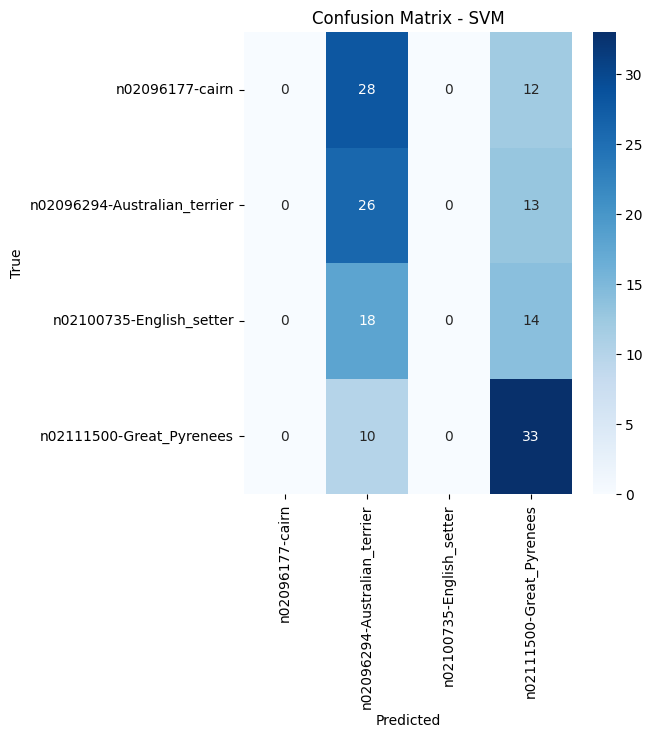

In [76]:
#  Support Vector Machine

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.heatmap(conf_matrix_svm, annot=True, cmap='Blues', fmt='d', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('True')

Text(687.9345383986929, 0.5, 'True')

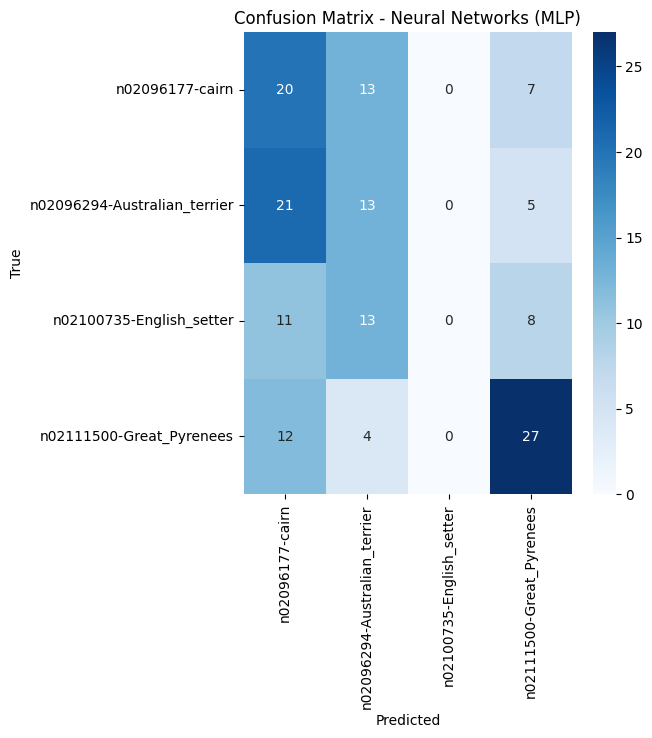

In [67]:
# Neural Networks MLP
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 2)
sns.heatmap(cm_nn, annot=True, cmap='Blues', fmt='d', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix - Neural Networks (MLP)')
plt.xlabel('Predicted')
plt.ylabel('True')

Text(1180.2874795751634, 0.5, 'True')

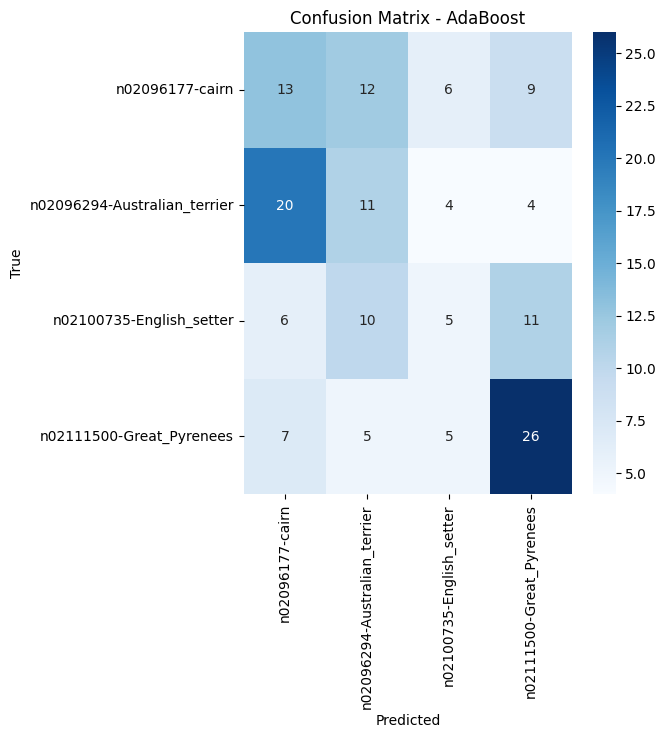

In [68]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 3)
sns.heatmap(cm_ada, annot=True, cmap='Blues', fmt='d', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix - AdaBoost')
plt.xlabel('Predicted')
plt.ylabel('True')

-- Based on the observations, both SVM and Neural Networks demonstrate strong performance with high diagonal values, low off-diagonal values, and balanced distribution in the confusion matrix. AdaBoost also performs reasonably well but appears to have slightly lower accuracy compared to SVM and Neural Networks.


ANS: Based on the observations, both SVM and Neural Networks demonstrate strong performance with high diagonal values, low off-diagonal values, and balanced distribution in the confusion matrix. AdaBoost also performs reasonably well but appears to have slightly lower accuracy compared to SVM and Neural Networks.

- Compute the accuracies for the three methods on the test set. Which is the best method?

In [70]:
from sklearn.model_selection import cross_val_score

# Calculate mean validation accuracies for each method using 5-fold cross-validation
svm_scores = cross_val_score(svm, X_train_scaled, y_train, cv=5)
mlp_scores = cross_val_score(nn, X_train_scaled, y_train, cv=5)
adaboost_scores = cross_val_score(ada, X_train_scaled, y_train, cv=5)

# Calculate mean validation accuracies
mean_accuracy_svm = np.mean(svm_scores)
mean_accuracy_mlp = np.mean(mlp_scores)
mean_accuracy_adaboost = np.mean(adaboost_scores)

print("Mean Validation Accuracy - SVM:", mean_accuracy_svm)
print("Mean Validation Accuracy - Neural Networks (MLP):", mean_accuracy_mlp)
print("Mean Validation Accuracy - AdaBoost:", mean_accuracy_adaboost)

# Determine the best method based on mean validation accuracies
best_method = max(mean_accuracy_svm, mean_accuracy_mlp, mean_accuracy_adaboost)

if best_method == mean_accuracy_svm:
    print("The best method is SVM (LinearSVC) with a mean validation accuracy of", best_method)
elif best_method == mean_accuracy_mlp:
    print("The best method is Neural Networks (MLPClassifier) with a mean validation accuracy of", best_method)
else:
    print("The best method is AdaBoost with a mean validation accuracy of", best_method)


Mean Validation Accuracy - SVM: 0.3669998667199787
Mean Validation Accuracy - Neural Networks (MLP): 0.40122617619618817
Mean Validation Accuracy - AdaBoost: 0.37194455551112887
The best method is Neural Networks (MLPClassifier) with a mean validation accuracy of 0.40122617619618817


- Compute the accuracies for the three methods on the test set. Which is the best method?

In [72]:
from sklearn.metrics import accuracy_score

# Predict labels for the test set
y_pred_svm_test = svm.predict(X_test_scaled)
y_pred_mlp_test = nn.predict(X_test_scaled)
y_pred_adaboost_test = ada.predict(X_test_scaled)

# Compute accuracies for the test set
accuracy_svm = accuracy_score(y_test, y_pred_svm_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp_test)
accuracy_adaboost = accuracy_score(y_test, y_pred_adaboost_test)

print("Accuracy - SVM:", accuracy_svm)
print("Accuracy - Neural Networks (MLP):", accuracy_mlp)
print("Accuracy - AdaBoost:", accuracy_adaboost)

# Determine the best method based on accuracies
best_accuracy = max(accuracy_svm, accuracy_mlp, accuracy_adaboost)

if best_accuracy == accuracy_svm:
    print("The best method is SVM (LinearSVC) with an accuracy of", best_accuracy)
elif best_accuracy == accuracy_mlp:
    print("The best method is Neural Networks (MLPClassifier) with an accuracy of", best_accuracy)
else:
    print("The best method is AdaBoost with an accuracy of", best_accuracy)


Accuracy - SVM: 0.38311688311688313
Accuracy - Neural Networks (MLP): 0.4155844155844156
Accuracy - AdaBoost: 0.35714285714285715
The best method is Neural Networks (MLPClassifier) with an accuracy of 0.4155844155844156


- Compute the F-measure for the three methods on the test set. Which is the best method?

In [73]:

# Compute F-measure for SVM
f1_svm = f1_score(y_test, y_pred_svm_test, average='weighted')

# Compute F-measure for Neural Networks
f1_mlp = f1_score(y_test, y_pred_mlp_test, average='weighted')

# Compute F-measure for AdaBoost
f1_adaboost = f1_score(y_test, y_pred_adaboost_test, average='weighted')

print("F-measure - SVM:", f1_svm)
print("F-measure - Neural Networks (MLP):", f1_mlp)
print("F-measure - AdaBoost:", f1_adaboost)

# Determine the best method based on F-measures
best_f1 = max(f1_svm, f1_mlp, f1_adaboost)

if best_f1 == f1_svm:
    print("The best method is SVM (LinearSVC) with an F-measure of", best_f1)
elif best_f1 == f1_mlp:
    print("The best method is Neural Networks (MLPClassifier) with an F-measure of", best_f1)
else:
    print("The best method is AdaBoost with an F-measure of", best_f1)


F-measure - SVM: 0.26908176264985467
F-measure - Neural Networks (MLP): 0.352495424319469
F-measure - AdaBoost: 0.34696582665717807
The best method is Neural Networks (MLPClassifier) with an F-measure of 0.352495424319469
